In [11]:
import os
import warnings
import pandas as pd
import math
import numpy as np
import datetime
import inflection
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from tabulate import tabulate
from boruta import BorutaPy
from pathlib import Path

from IPython.core.display import HTML
from IPython.display import Image

from xgboost import XGBRegressor
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.model_selection import RandomizedSearchCV, train_test_split, BaseCrossValidator
from skopt import BayesSearchCV, space 

## 0.1. Helper functions

In [12]:
# Define function to calculate cramer v 
def cramerv(x,y):
    cm = pd.crosstab(x,y).values
    n = cm.sum()
    r, k = cm.shape

    chi2 = stats.chi2_contingency(cm)[0]
    chis2corr = max(0, chi2 - (k-1)*(r-1)/(n-1))
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt((chis2corr/n) / min(kcorr-1, rcorr-1))

def mean_absolute_percentage_error(y, yhat):
    return  np.mean( np.abs( (y - yhat) / y ) )

def mean_percentage_error(y, yhat):
    return  np.mean((y - yhat) / y)


def ml_error (model_name: str, y: pd.Series, yhat: pd.Series) -> pd.DataFrame:
    mae = mean_absolute_error(y, yhat)
    mape = mean_absolute_percentage_error(y, yhat)
    rmse = np.sqrt(mean_absolute_error(y, yhat))
    
    return pd.DataFrame({'Model Name': model_name,
                         'MAE': mae,
                         'MAPE': mape,
                         'RMSE': rmse}, index=[0])    

def cross_val(model, kfold, x_training):
    mae_list = []
    mape_list = []
    rmse_list = []

    print(f'Model in Trainning: {model.__class__.__name__}')

    # Creating the cross validation folds
    for k in reversed(range(1, kfold+1)):
        print(f'Kfold: {k}')

        start_lim = x_training['date'].max() - datetime.timedelta(k*6*7)      # We decide early that the window to split the data in tranning and test will use units of 6 weeks. 
        end_lim = x_training['date'].max() - datetime.timedelta((k-1)*6*7)

        # Filtering dataframe
        trainning = x_training[x_training['date'] < start_lim]
        validation = x_training[(x_training['date'] >= start_lim) & (x_training['date'] <= end_lim)] 

        # Cross validation datasets (just removing the date and sales columns again, since this columns will not be used on tranning)
        xtrainning = trainning.drop(columns=['date', 'sales'], axis = 1)
        ytrainning = trainning['sales']

        xvalidation = validation.drop(columns=['date', 'sales'], axis = 1)
        yvalidation = validation['sales']

        # Model tranning 
        m = model.fit(xtrainning, ytrainning)
        yhat = m.predict(xvalidation)

        # Performance
        results = ml_error(model.__class__.__name__, np.expm1(yvalidation), np.expm1(yhat))
        mae_list.append(results['MAE'])
        mape_list.append(results['MAPE'])
        rmse_list.append(results['RMSE'])

    print('---------------------------------------------')

    return pd.DataFrame({'Model Name': model.__class__.__name__ ,
                         'MAE_CV': np.round(np.mean(mae_list), 2).astype(str) + '+/-' + np.round(np.std(mae_list), 2).astype(str),
                         'MAPE_CV': np.round(np.mean(mape_list), 2).astype(str) + '+/-' + np.round(np.std(mape_list), 2).astype(str),
                         'RMSE_CV': np.round(np.mean(rmse_list), 2).astype(str) + '+/-' + np.round(np.std(rmse_list), 2).astype(str),
                         }, index = [0])

class TimeSeriesWindowSplit(BaseCrossValidator):
    """
    CV temporal com janelas fixas retroativas (ex.: 6 semanas).
    Use .fit(X, y, groups=dates) — 'dates' é um vetor de datas (len == len(X) == len(y)).
    """
    def __init__(self, n_splits=5, window_weeks=6, drop_empty=True):
        self.n_splits = n_splits
        self.window_weeks = window_weeks
        self.drop_empty = drop_empty

    def get_n_splits(self, X=None, y=None, groups=None):
        return self.n_splits

    def split(self, X, y=None, groups=None):
        if groups is None:
            raise ValueError("Passe as datas via 'groups' em .fit(X, y, groups=dates).")

        # Converte para Series de datetime e cria índices POSICIONAIS 0..n-1
        dates = pd.to_datetime(pd.Series(groups)).reset_index(drop=True)
        n = len(dates)
        idx = np.arange(n)

        end_date = dates.max()
        window = datetime.timedelta(weeks=self.window_weeks)

        produced = 0
        # Gera n_splits janelas de trás pra frente (cada uma com 'window_weeks')
        for k in range(self.n_splits, 0, -1):
            start = end_date - k * window
            end   = end_date - (k - 1) * window

            mask_val   = (dates >= start) & (dates <= end)
            mask_train = (dates < start)

            train_idx = idx[mask_train.to_numpy()]
            val_idx   = idx[mask_val.to_numpy()]

            if (len(train_idx) == 0 or len(val_idx) == 0):
                print(f"⚠️ Split {k} descartado (train={len(train_idx)}, test={len(val_idx)})")
                if self.drop_empty:
                    continue
                else:
                    raise ValueError(
                        f"Fold vazio em k={k}: train={len(train_idx)}, val={len(val_idx)} "
                        f"(janela {start.date()}..{end.date()}). Ajuste n_splits/window."
                    )

            produced += 1
            yield train_idx, val_idx

        if produced == 0:
            raise ValueError("Nenhum fold válido foi produzido — reduza n_splits ou aumente window_weeks.")

# --- Classe wrapper para injetar early stopping ---
class XGBWithEarlyStopping(XGBRegressor):
    def fit(self, X, y, **kwargs):
        # Se o CV passar um "eval_set", usa; caso contrário, cria usando o último 20% dos dados
        if "eval_set" not in kwargs:
            n = int(0.8 * X.shape[0])
            X_train, X_val = X[:n], X[n:]
            y_train, y_val = y[:n], y[n:]
            kwargs["eval_set"] = [(X_val, y_val)]
        # sempre força early stopping
        kwargs["early_stopping_rounds"] = kwargs.get("early_stopping_rounds", 100)
        kwargs["verbose"] = False
        return super().fit(X, y, **kwargs)            

def jupyter_settings():
    %matplotlib inline
    # %pylab inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 16
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
# Histogram default params
histogram_args = {'stat': 'density',
                    'kde': True,
                    'kde_kws': dict(cut=3),
                    'bins': 50
                    }

### 0.1.1 Settings

In [13]:
jupyter_settings()

# Ignoring the Future Warnings of XGBoost so they dont get printed in the loop 
warnings.filterwarnings(
    "ignore",
    message=r".*Series\.base is deprecated.*",
    category=FutureWarning
)

## 0.2. Loading data

In [14]:
root = Path().resolve()
data_dir = root / 'data'

df_sales_raw = pd.read_csv(data_dir / 'raw' /'train.csv', low_memory=False)
df_test_raw = pd.read_csv(data_dir / 'raw' /'test.csv', low_memory=False)
df_store_raw = pd.read_csv(data_dir / 'raw' /'store.csv', low_memory=False)

# Merge
df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

# 1.0. Data Description

In [15]:
df_raw_1 = df_raw.copy()

old_cols = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
           'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
           'CompetitionDistance', 'CompetitionOpenSinceMonth',
           'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
           'Promo2SinceYear', 'PromoInterval']

# Changing columns to snakecase
snakecase = lambda x: inflection.underscore(x)
new_cols = list(map(snakecase, old_cols))

# Rename columns
df_raw_1.columns = new_cols


## 1.2. Data dimensions

In [16]:
df_raw_1.shape

(1017209, 18)

## 1.3. Data Types

In [17]:
df_raw_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 18 columns):
 #   Column                        Non-Null Count    Dtype  
---  ------                        --------------    -----  
 0   store                         1017209 non-null  int64  
 1   day_of_week                   1017209 non-null  int64  
 2   date                          1017209 non-null  object 
 3   sales                         1017209 non-null  int64  
 4   customers                     1017209 non-null  int64  
 5   open                          1017209 non-null  int64  
 6   promo                         1017209 non-null  int64  
 7   state_holiday                 1017209 non-null  object 
 8   school_holiday                1017209 non-null  int64  
 9   store_type                    1017209 non-null  object 
 10  assortment                    1017209 non-null  object 
 11  competition_distance          1014567 non-null  float64
 12  competition_open_since_month

In [18]:
# change date to datetime64
df_raw_1['date'] = pd.to_datetime(df_raw_1['date'])

## 1.4. Missing values

In [19]:
# checking NA count explicitly
df_raw_1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5. Fillout NA

In [20]:
# competition_distance 
df_raw_1['competition_distance'].fillna(200000.0, inplace=True)

# competition_open_since_month 

    # Usar a bilbioteca math quando quiser aplicar soluções de substituição de NaN através de lambda function nas linhas, fillna
    # e replace não funcionam pois são feitas para atuar unicamente em dataframes.

df_raw_1['competition_open_since_month'] = (df_raw_1.apply(lambda x: x['date'].month 
                                                           if math.isnan(x['competition_open_since_month']) 
                                                           else x['competition_open_since_month'] , axis=1))

# competition_open_since_year     

df_raw_1['competition_open_since_year'] = (df_raw_1.apply(lambda x: x['date'].year 
                                                           if math.isnan(x['competition_open_since_year']) 
                                                           else x['competition_open_since_year'] , axis=1))
# promo2_since_week  

df_raw_1['promo2_since_week'] = (df_raw_1.apply(lambda x: x['date'].week  
                                                if math.isnan(x['promo2_since_week']) 
                                                else x['promo2_since_week'] , axis=1))

# promo2_since_year

df_raw_1['promo2_since_year'] = (df_raw_1.apply(lambda x: x['date'].year  
                                                if math.isnan(x['promo2_since_year']) 
                                                else x['promo2_since_year'] , axis=1))

# promo_interval 

month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Set', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

df_raw_1['promo_interval'].fillna(0, inplace=True)

df_raw_1['month_map'] = df_raw_1['date'].dt.month.map(month_map)

df_raw_1['is_promo'] = df_raw_1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)

In [21]:
df_raw_1.head(2)

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,31.0,2015.0,0,Jul,0
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",Jul,1


## 1.6 Reviewing Columns Types and Missing values again

In [22]:
df_raw_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 20 columns):
 #   Column                        Non-Null Count    Dtype         
---  ------                        --------------    -----         
 0   store                         1017209 non-null  int64         
 1   day_of_week                   1017209 non-null  int64         
 2   date                          1017209 non-null  datetime64[ns]
 3   sales                         1017209 non-null  int64         
 4   customers                     1017209 non-null  int64         
 5   open                          1017209 non-null  int64         
 6   promo                         1017209 non-null  int64         
 7   state_holiday                 1017209 non-null  object        
 8   school_holiday                1017209 non-null  int64         
 9   store_type                    1017209 non-null  object        
 10  assortment                    1017209 non-null  object        
 11

In [23]:
df_raw_1['competition_open_since_month'] = df_raw_1['competition_open_since_month'].astype(int)
df_raw_1['competition_open_since_year'] = df_raw_1['competition_open_since_year'].astype(int)

df_raw_1['promo2_since_week'] = df_raw_1['promo2_since_week'].astype(int)
df_raw_1['promo2_since_year'] = df_raw_1['promo2_since_year'].astype(int)

In [24]:
df_raw_1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

## 1.7 Descriptive Statistical Analysis 

In [25]:
df_raw_1.select_dtypes('number').columns

Index(['store', 'day_of_week', 'sales', 'customers', 'open', 'promo',
       'school_holiday', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo'],
      dtype='object')

In [26]:
num_attributes = df_raw_1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df_raw_1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])


### 1.7.1 Numeric Attributes

In [27]:
range_ = lambda x: (x.max() - x.min())

m = num_attributes.agg([np.mean, np.median, np.std, 'min', 'max', range_, 'skew', 'kurt']).T
m.rename(columns = {'<lambda>': 'range', 'kurt': 'kurtosis'})


,mean,median,std,min,max,range,skew,kurtosis
store,558.429727,558.0,321.908651,1.0,1115.0,1114.0,-0.000955,-1.200524
day_of_week,3.998341,4.0,1.997391,1.0,7.0,6.0,0.001593,-1.246873
sales,5773.818972,5744.0,3849.926175,0.0,41551.0,41551.0,0.641460,1.778375
customers,633.145946,609.0,464.411734,0.0,7388.0,7388.0,1.598650,7.091773
open,0.830107,1.0,0.375539,0.0,1.0,1.0,-1.758045,1.090723
promo,0.381515,0.0,0.485759,0.0,1.0,1.0,0.487838,-1.762018
school_holiday,0.178647,0.0,0.383056,0.0,1.0,1.0,1.677842,0.815154
competition_distance,5935.442677,2330.0,12547.652996,20.0,200000.0,199980.0,10.242344,147.789712
competition_open_since_month,6.786849,7.0,3.311087,1.0,12.0,11.0,-0.042076,-1.232607
competition_open_since_year,2010.324840,2012.0,5.515593,1900.0,2015.0,115.0,-7.235657,124.071304


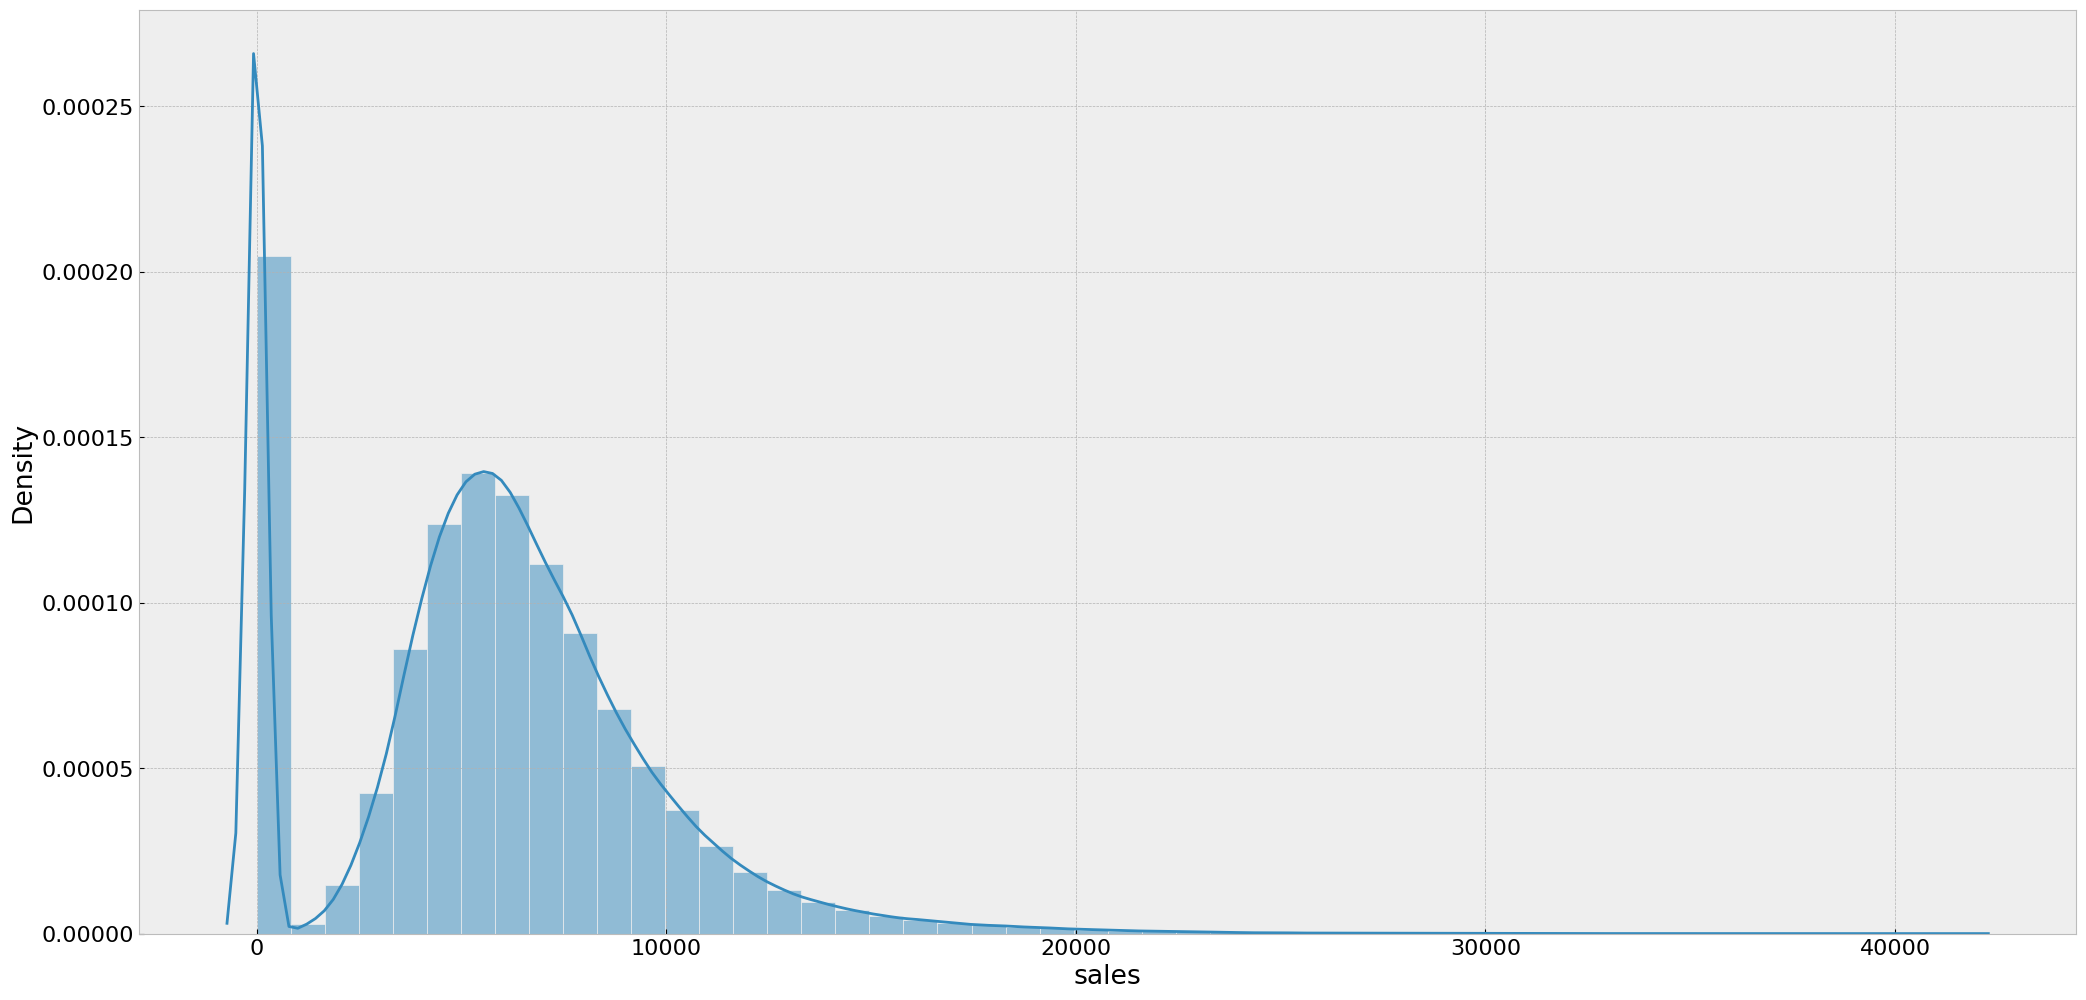

In [28]:
fig = sns.histplot(df_raw_1['sales'], **histogram_args)
plt.show()


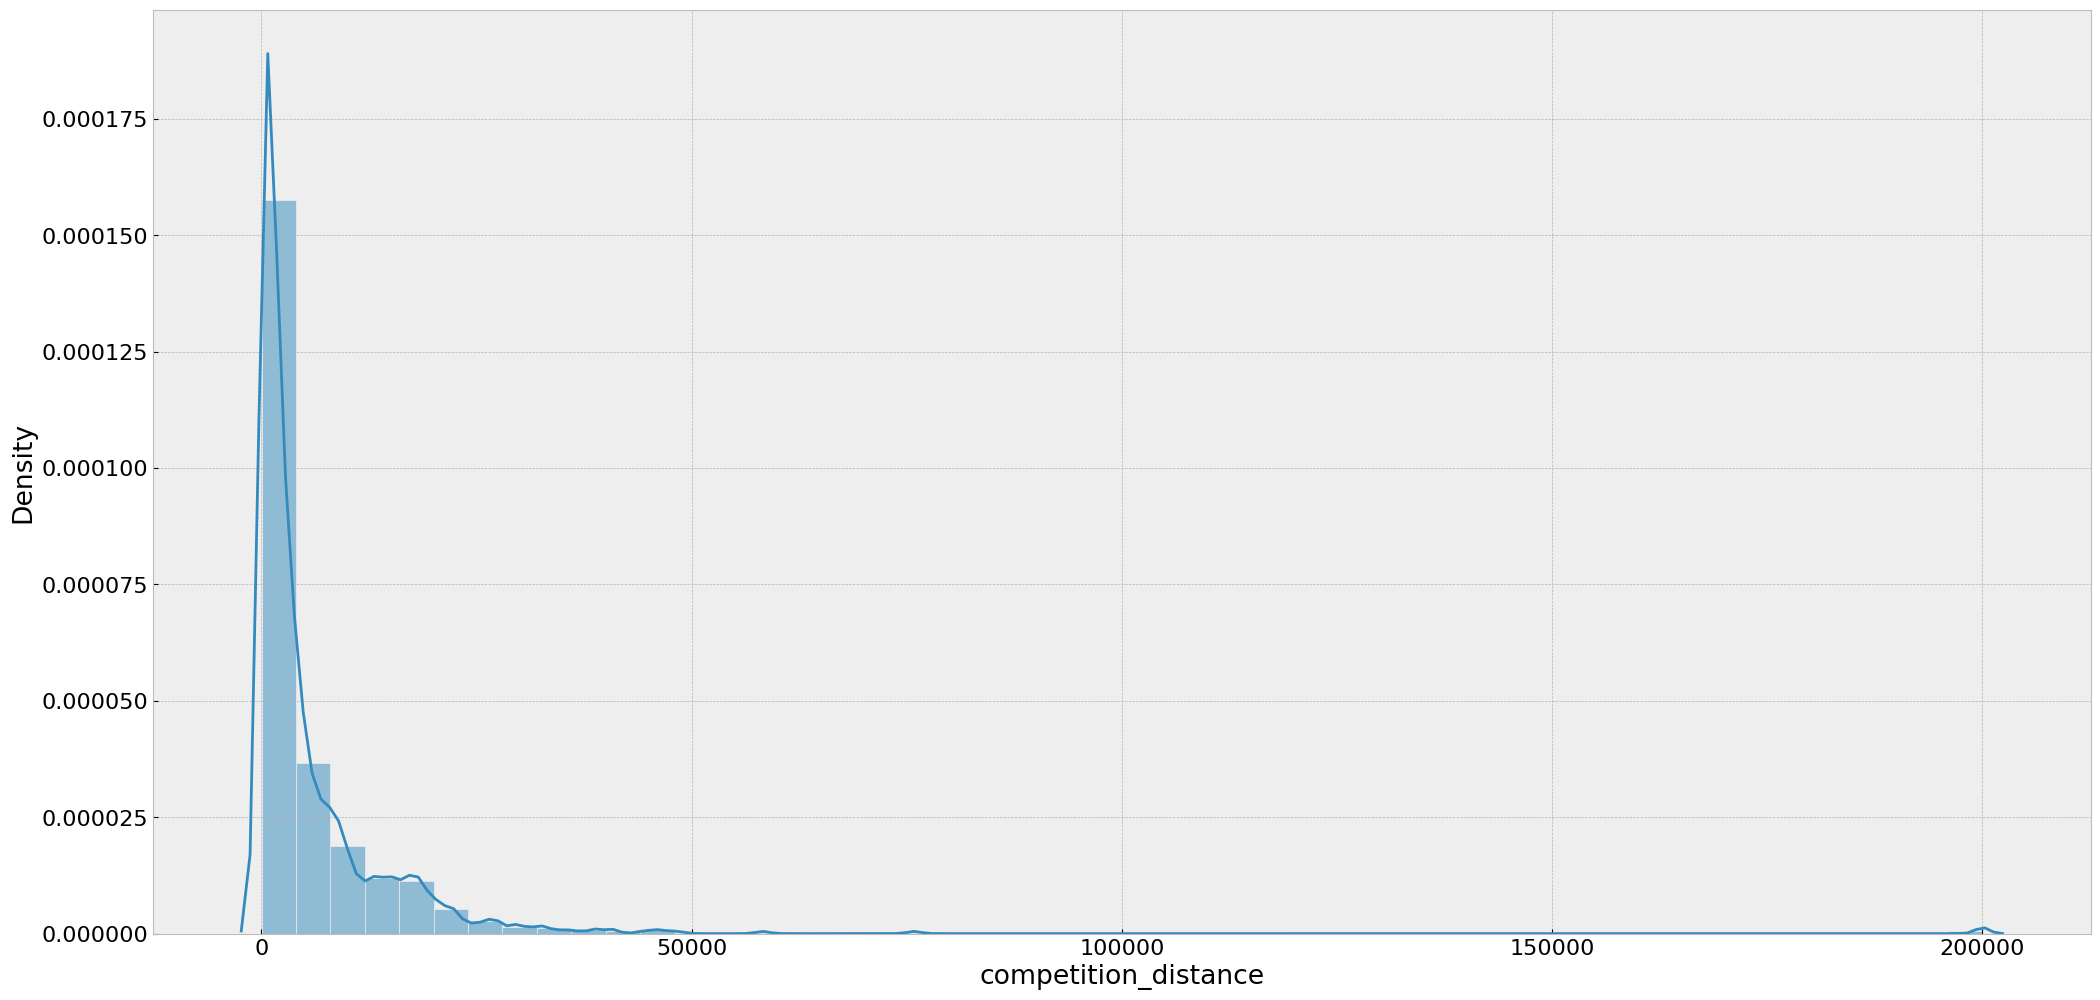

In [29]:
fig = sns.histplot(df_raw_1['competition_distance'], **histogram_args)
plt.show()

### 1.7.2 Categorical Attributes

In [30]:
cat_attributes.nunique()

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

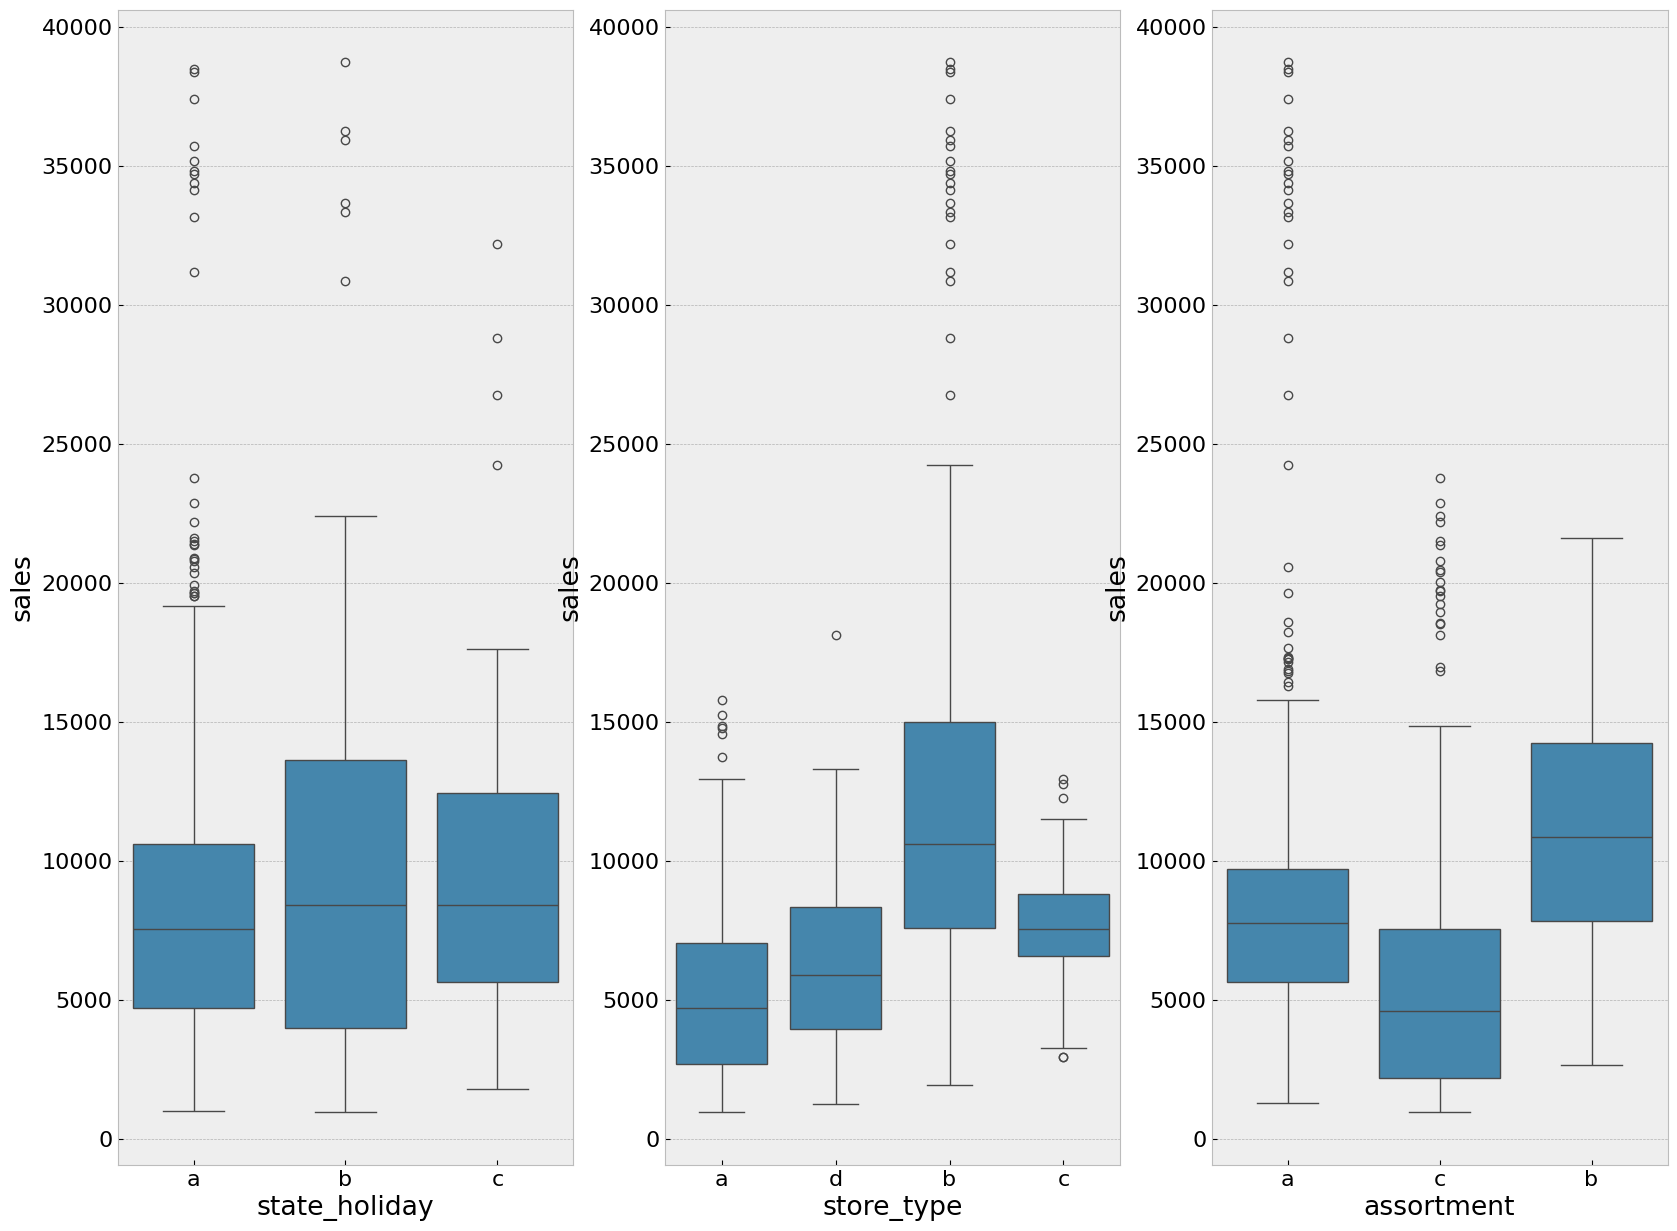

In [31]:
aux1 = df_raw_1[(df_raw_1['state_holiday'] != '0') & (df_raw_1['sales'] > 0)]

plt.figure(figsize=(20,15))

plt.subplot(1,3,1)
sns.boxplot(x= 'state_holiday', y= 'sales', data= aux1)

plt.subplot(1,3,2)
sns.boxplot(x= 'store_type', y= 'sales', data= aux1)

plt.subplot(1,3,3)
sns.boxplot(x= 'assortment', y= 'sales', data= aux1)

plt.show()

# 2.0. Feature Engineering

In [32]:
df2 = df_raw_1.copy()

## 2.1. Hypothesis Mind Map

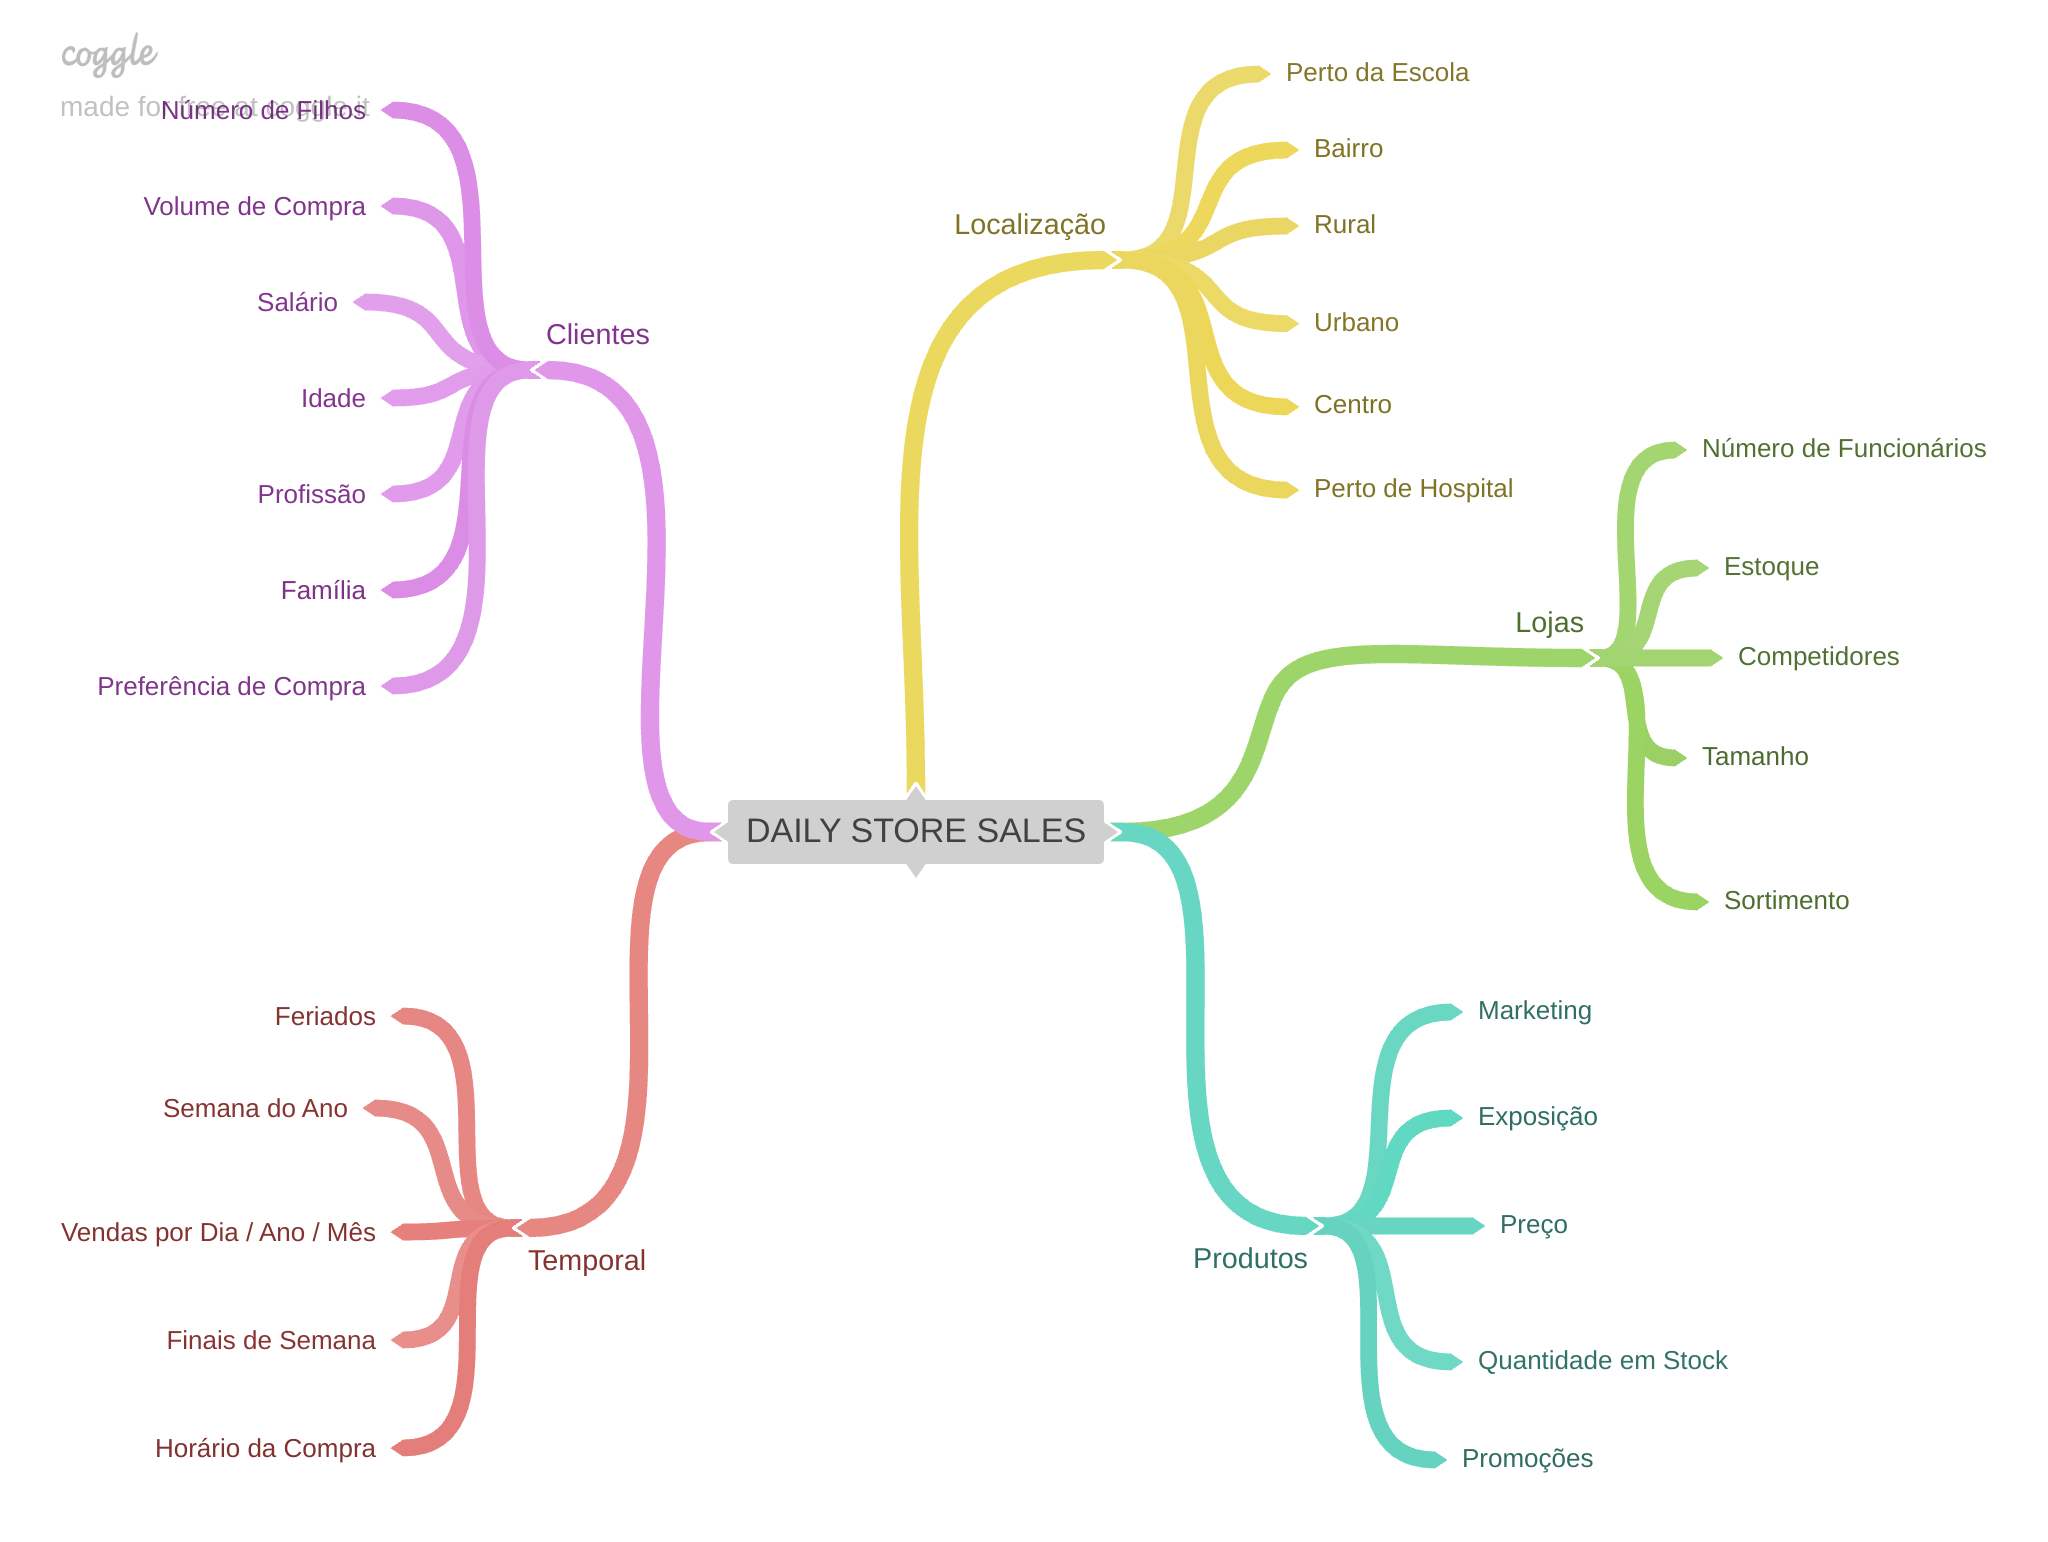

In [33]:
# Fazer o mapa no Coggle e importar com Ipython.core image library
Image(root / 'img/mindmap_hypothesis.png', width= 800, height= 800)

## 2.2. Hypothesis Creation

In [34]:
# Brainstorm reunion or making up by yourself

### 2.2.1 Store Hypothesis

**1.** Lojas com número maior de funcionários deveriam vender mais.

**2.** Lojas com maior capacidade de estoque deveriam vender mais.

**3.** Lojas com maior porte deveriam vender mais.

**4.** Lojas com maior sortimentos deveriam vender mais.

**5.** Lojas com competidores mais próximos deveriam vender menos.

**6.** Lojas com competidores à mais tempo deveriam vendem mais.

### 2.2.2 Product Hypothesis

**1.** Lojas que investem mais em Marketing deveriam vender mais.
    
**2.** Lojas com maior exposição de produto deveriam vender mais.

**3.** Lojas com produtos com preço menor deveriam vender mais.

**5.** Lojas com promoções mais agressivas ( descontos maiores ), deveriam vender mais.

**6.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**7.** Lojas com mais dias de promoção deveriam vender mais.
    
**8.** Lojas com mais promoções consecutivas deveriam vender mais.

### 2.2.3 Time Hypothesis

**1.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**2.** Lojas deveriam vender mais ao longo dos anos.

**3.** Lojas deveriam vender mais no segundo semestre do ano.

**4.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**5.** Lojas deveriam vender menos aos finais de semana.

**6.** Lojas deveriam vender menos durante os feriados escolares

## 2.3. Final Hypothesis List

**Selection of highest priority hypothesis**

**1.** Lojas com maior sortimentos deveriam vender mais.

**2.** Lojas com competidores mais próximos deveriam vender menos.

**3.** Lojas com competidores à mais tempo deveriam vendem mais.

**4.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**5.** Lojas com mais dias de promoção deveriam vender mais.

**7.** Lojas com mais promoções consecutivas deveriam vender mais.

**8.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**9.** Lojas deveriam vender mais ao longo dos anos.

**10.** Lojas deveriam vender mais no segundo semestre do ano.

**11.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**12.** Lojas deveriam vender menos aos finais de semana.

**13.** Lojas deveriam vender menos durante os feriados escolares.


## 2.4. Feature Transformations

In [35]:
#year
df2['year'] = df2['date'].dt.year

#month
df2['month'] = df2['date'].dt.month

#day
df2['day'] = df2['date'].dt.day

#week of year
df2['week_of_year'] = df2['date'].dt.isocalendar().week

# year - week (mask)
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

#competition since
df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis=1)

# versão simplificada do script da aula
df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).dt.days

# converte ano-semana da promo em data da promo e calcula a diferença entre a data da promo e a data do registro de venda 
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7))
df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).dt.days

#assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')


In [36]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


# 3.0. Variable Filtering

## 2.5. Row filtering 

In [37]:
df3 = df2.copy()

In [38]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 2.6. Column selection

In [ ]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop(cols_drop, axis=1)

In [41]:
# Saving the dataset that will be used in the EDA steps
df3.to_csv(data_dir / 'processed' / 'df_cleaned.csv', index=False)